# Matrix mult from the foundations

In [1]:
import operator

In [2]:
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b), f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq, '==')    

# Get data

In [3]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [4]:
path = Path('/home/justin/.fastai/data/mnist.pkl.gz')

In [5]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
x_train,y_traain,x_valid,y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [7]:
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 array([5, 0, 4, 1, ..., 0, 8, 4, 8]),
 (50000,),
 0,
 9)

In [8]:
assert n==y_train.shape[0]==50000
test_eq(c, 28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [9]:
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
img = x_train[0]

In [11]:
img.view(28,28).type()

'torch.FloatTensor'

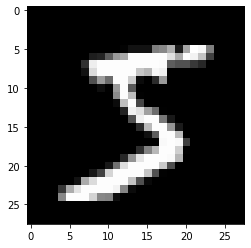

In [12]:
plt.imshow(img.view((28,28)))

# Initial Python Model

In [13]:
weights = torch.randn(784, 10)

In [14]:
bias = torch.zeros(10)

### Matrix Multiplication

In [15]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [16]:
m1 = x_valid[:5]
m2 = weights

In [17]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [18]:
%time t1=matmul(m1, m2)

CPU times: user 525 ms, sys: 1.3 ms, total: 526 ms
Wall time: 527 ms


In [19]:
len(x_train)

50000

### Elementwise ops

In [20]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [21]:
a+b

tensor([12., 14.,  3.])

In [22]:
(a<b).float().mean()

tensor(0.6667)

In [23]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [24]:
(m*m).sum().sqrt()

tensor(16.8819)

### Elementwise matmul

In [25]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [26]:
%timeit -n 10 _=matmul(m1, m2)

891 µs ± 148 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
890.1/5

178.02

In [28]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [29]:
test_near(t1, matmul(m1, m2))

### Broadcasting

In [30]:
a

tensor([10.,  6., -4.])

In [31]:
a > 0

tensor([ True,  True, False])

In [32]:
a + 1

tensor([11.,  7., -3.])

In [33]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [34]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### vector to matrix

In [35]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [36]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [37]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [38]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [39]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [40]:
t = c.expand_as(m)

In [41]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [42]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [43]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [44]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [45]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [46]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [47]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [48]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [49]:
c.shape, c[None,:].shape, c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [50]:
c[None].shape, c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [51]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [52]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [53]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [54]:
%timeit -n 10 _=matmul(m1,m2)

194 µs ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
test_near(t1, matmul(m1, m2))

# Broadcasting rules

In [56]:
c[None, :]

tensor([[10., 20., 30.]])

In [57]:
c[None, :].shape

torch.Size([1, 3])

In [58]:
c[:, None].shape

torch.Size([3, 1])

In [59]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [60]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

# Einstein summation

In [61]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [62]:
%timeit _=matmul(m1, m2)

22.5 µs ± 215 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Pytorch operation

In [63]:
%timeit t2 = m1.matmul(m2)

4.49 µs ± 49.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [64]:
t2 = m1@m2

In [65]:
test_near(t1, t2)

In [66]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

# Forward and backward pass

In [67]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def normalize(x, m, s): return (x-m)/s

In [68]:
x_train, y_train, x_valid, y_valid = get_data()

In [69]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [70]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [71]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(-6.2598e-06), tensor(1.))

In [72]:
def test_near_zero(a, tol=1e-3): assert a.abs()<tol, f'Near zero:{a}'

In [73]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [74]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

# Basic architecture

In [75]:
nh = 50

In [76]:
w1 = torch.randn(m, nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [77]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [78]:
x_valid.mean(), x_valid.std()

(tensor(-0.0059), tensor(0.9924))

In [79]:
def lin(x, w, b): return x@w + b

In [80]:
t = lin(x_valid, w1, b1)

In [81]:
t.mean(), t.std()

(tensor(-0.1505), tensor(0.9719))

In [82]:
def relu(x): return x.clamp_min(0.)

In [83]:
t = relu(lin(x_valid, w1, b1))

In [84]:
t.mean(), t.std()

(tensor(0.3126), tensor(0.5090))

In [85]:
# kaiming init
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [86]:
w1.mean(), w1.std()

(tensor(-0.0003), tensor(0.0504))

In [87]:
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.6002), tensor(0.8306))

In [88]:
from torch.nn import init

In [89]:
w1 = torch.zeros(m, nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_valid, w1, b1))

In [90]:
w1.mean(), w1.std()

(tensor(0.0006), tensor(0.0504))

In [91]:
t.mean(), t.std()

(tensor(0.5452), tensor(0.8226))

In [92]:
w1.shape

torch.Size([784, 50])

In [93]:
torch.nn.Linear(m,nh).weight.shape

torch.Size([50, 784])

In [94]:
def relu(x): return x.clamp_min(0) - 0.5

In [95]:
w1 = torch.randn(m,nh)*math.sqrt(2/m)
t1 = relu(lin(x_valid, w1, b1))
t1.mean(), t1.std()

(tensor(0.2188), tensor(0.9704))

In [96]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [97]:
%timeit _=model(x_valid)

4.16 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [98]:
assert model(x_valid).shape == torch.Size([x_valid.shape[0],1])

# Loss function: MSE

In [99]:
model(x_valid).shape

torch.Size([10000, 1])

In [100]:
def mse(output, targ): return (output.squeeze() - targ).pow(2).mean()

In [101]:
y_train, y_valid = y_train.float(), y_valid.float()

In [102]:
preds = model(x_train)

In [103]:
preds.shape

torch.Size([50000, 1])

In [104]:
mse(preds, y_train)

tensor(32.9905)

# Gradients and backward pass

In [105]:
def mse_grad(inp, targ):
    inp.g = 2 * (inp.squeeze() - targ).unsqueeze(-1)/inp.shape[0]

In [106]:
def relu_grad(inp, out):
    inp.g = (inp>0).float() * out.g

In [107]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [108]:
def forward_and_backward(inp, targ):
    l1 = inp@w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    loss = mse(out, targ)
    
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [109]:
forward_and_backward(x_train, y_train)

In [110]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

In [111]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [112]:
def forward(inp, targ):
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    return mse(out, targ)

In [113]:
loss = forward(xt2, y_train)

In [114]:
loss.backward()

In [115]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig )

# Layers as classes

In [116]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0)-0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [117]:
class Lin():
    def __init__(self, w, b): self.w, self.b = w,b
    
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [118]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [119]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [120]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [121]:
%time loss = model(x_train, y_train)

CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 24 ms


In [122]:
%time model.backward()

CPU times: user 6.2 s, sys: 2.33 s, total: 8.53 s
Wall time: 1.6 s


In [123]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

# Module.forward()

In [124]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [125]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [126]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [127]:
class Mse(Module):
    def forward(self, inp, targ): return(inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1)/targ.shape[0]

In [128]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [129]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [130]:
%time loss = model(x_train, y_train)

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 30 ms


In [131]:
%time model.backward()

CPU times: user 361 ms, sys: 50.5 ms, total: 411 ms
Wall time: 70.3 ms


In [132]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

# Without einsum

In [133]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g@self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g= out.g.sum(0)

In [134]:
w1.g, b1.g, w2.g, b2.g = [None]*4

In [135]:
%time loss = model(x_train, y_train)

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 30.2 ms


In [136]:
%time model.backward()

CPU times: user 379 ms, sys: 75.9 ms, total: 455 ms
Wall time: 74.8 ms


In [137]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

# nn.Linear and nn.Module

In [138]:
from torch import nn

In [139]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [140]:
model = Model(m, nh, 1)

In [141]:
%time loss = model(x_train, y_train)

CPU times: user 143 ms, sys: 363 µs, total: 143 ms
Wall time: 24.8 ms


In [142]:
%time loss.backward()

CPU times: user 257 ms, sys: 3.55 ms, total: 261 ms
Wall time: 38.6 ms
